In this notebook we will explore the European Soccer Database and determine the FifaWorld 11 for the years (2007 - 2016). 

* We will be using a pitch visualization to depict our results using the mplsoccer package.
* We will also be using the ipywidgets to create interactive visualizations. 

* Mplsoccer gives you the ability to draw pitches in python. Complete guide, https://mplsoccer.readthedocs.io/en/latest/
* Ipywidgets allow you to interact with graphs within Jupyter notebooks. Complete guide, https://ipywidgets.readthedocs.io/en/latest/

In [ ]:
!pip install mplsoccer
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlite3
from mplsoccer.pitch import Pitch
import ipywidgets as widgets
from IPython.display import display
import os
import matplotlib.pyplot as plt

In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
path = "../input/soccer/database.sqlite" 
dataConnect = sqlite3.connect(path)

Match = pd.read_sql_query("SELECT * FROM Match",dataConnect)
PlayerA = pd.read_sql_query("SELECT * FROM Player_Attributes",dataConnect)
Player = pd.read_sql_query("Select * FROM Player",dataConnect)
Positions = pd.read_csv("../input/player-positions-for-european-soccer-database/player_positions.csv")

* Lets start by exploring the positions dataset since this will be crucial in determining which position each top player would be playing in

In [ ]:
Positions.head(10)

* We can see that the player positions are categorical columns containing numbers with each number, 1 to 5, representing the order of preference of the postition for that player with 1 being the primary position.

* We therefore pick the position corresponding to where the number 1 is for each player and make a new column called "Positions" by transposing the column headers so that they are within the newly created column 

* We would also fill any empty positions with "None". There is no significance for this but just to keep the data clean

In [ ]:
Positions['Position'] = (Positions[(Positions == 1).sum(axis =1)==1]==1).idxmax(axis =1)
Positions['Position'] = Positions['Position'].fillna("None")
Positions.head(1)


* Lets now merge the Player dataset with the positions dataset in order to get the player names. We will drop all the rest of the position columns and just keep the custom created column. 
* We now have a dataset with each players name and their position

In [ ]:
PlayerPos = pd.merge(Player,Positions,how = 'left',left_on = 'player_fifa_api_id',right_on = 'playerID' )
PlayerPos.drop(['id','player_fifa_api_id','height','weight','playerID','CAM','CB','CDM','CF','CM','GK','LB','LF','LM','LW','LWB','RB','RF','RM','RW','RWB','ST','SW'],axis = 'columns', inplace = True)
PlayerPos.head()

* To make things easier, we will convert the positions to a shorter form, namely, ['Midfielder','GoalKeeper','Defender','Forward']

In [ ]:
conditions = [(PlayerPos['Position'] == "CAM") | (PlayerPos['Position'] == "CDM") | (PlayerPos['Position'] == "CM") | (PlayerPos['Position'] == "LWB") |  (PlayerPos['Position'] == "RWB"),
             (PlayerPos['Position'] == "GK"),
             (PlayerPos['Position'] == "CB") | (PlayerPos['Position'] == "LB") | (PlayerPos['Position'] == "RB") | (PlayerPos['Position'] == "SW"),
             (PlayerPos['Position'] == "CF") | (PlayerPos['Position'] == "LF") | (PlayerPos['Position'] == "LW") | (PlayerPos['Position'] == "RF") | (PlayerPos['Position'] == "ST") | (PlayerPos['Position'] == "LM") | (PlayerPos['Position'] == "RM") ]

values = ['Midfielder','GoalKeeper','Defender','Forward']

PlayerPos['short_position'] = np.select(conditions,values)
PlayerPos

* Now we need to get the player attributes so that we can choose our World 11. We will combine the PlayerPos dataset that we created with the Player attributes dataset to get player rating oin different characteristics

In [ ]:
PlayerDetails = PlayerA.merge(PlayerPos,on = 'player_api_id', how = 'left')
PlayerDetails.head(1)

* Now here you can either calculate your own overall_rating by weighting different attributes depending on which position the player plays in, e.g you can select all the defensive attributes for a defender, give them high weight and then average them to get to an overall rating, or you could just pick the overall_rating characteristic provided by the dataset. 

* I chose to go with the overall_rating dataset since it resulted in better results in comparison to actual world 11 released by fifa

In [ ]:
PlayerDetails = PlayerDetails[['player_name','Position','birthday','date','overall_rating','short_position']]
PlayerDetails.head(1)

* We will drop any player that does not have an overall rating. 

* Again you can choose to get an average of the characteristics if the overall_rating is not filled in. However, this was not the case for the top players so I did not have to do that

In [ ]:
PlayerDetails = PlayerDetails.dropna(subset = ['overall_rating','date'])
PlayerDetails.isnull().sum()

* For further computation we would require date columns to be recognized as date columns by python therefore we will convert the following columns to date using the to_datetime pandas method

In [ ]:
PlayerDetails['date'] = pd.to_datetime(PlayerDetails['date'])
PlayerDetails['birthday'] = pd.to_datetime(PlayerDetails['birthday'])

In [ ]:
PlayerDetails['year'] = PlayerDetails['date'].dt.year

We now need to determine the world 11 for each year. We will make a function that will take 4 arguments. 
1. The first argument will be the relevant dataset
2. The second will be the position of the player
3. The third argument will be the year for which you wish to determine the top players
4. Will be the count of players you need for that particular positoion

In [ ]:
def Top_N_Players(df,position,year,n):
    Top_filter = df[(df['short_position'] == position) & (df['year'] == year)] 
    Top_filter = Top_filter.groupby(['year','player_name']).agg({'overall_rating': ['max']})
    Top_filter.columns = ['overall_rating']
    Top_filter = Top_filter.sort_values(['year','overall_rating'],ascending=(False)).groupby('year').head(n)
    Top_filter = Top_filter.reset_index()
    return Top_filter

* We will create another function that, when provided with a year, will output the top 11 players for that particular year based on overall_rating using the Top_N_Players function

* I have specifically choosen a 4-3-3 formation. You can change it to choose any you want. 

In [ ]:
def Top_Team(y):
    GoalKeeper = Top_N_Players(PlayerDetails,"GoalKeeper",y,1)
    Defender = Top_N_Players(PlayerDetails,"Defender",y,4)
    Midfielder = Top_N_Players(PlayerDetails,"Midfielder",y,3)
    Forward = Top_N_Players(PlayerDetails,"Forward",y,3)
    Team  = GoalKeeper.append([Defender,Midfielder,Forward])
    Team.reset_index()
    return Team

* We can now test our function for a particular year

In [ ]:
test = Top_Team(2007)
lst = test.player_name.tolist()
lst

* We now want to showcase the results for the World 11 in an interactive widget. 

* We will start of by creating a function that sorts a list. This will be used to sort years for which we have the data and use this in a drop down widget from which a person could select any year and the World 11 for that year will be outputted

In [ ]:
#ALL = 'ALL'
def unique_sorted_values_plus_ALL(array):
    unique = array.unique().tolist()
    unique.sort()
    #unique.insert(0)
    return unique

We will create two variables that allow capturing outputs.
1. The first output variable will be used to catch the dropdown widget
2. The second output widget will be used to capture the visualization for our World 11 in a pitch like graph

In [ ]:
output = widgets.Output()
plot_output = widgets.Output()

* We now assign the year values to the dropdown widget, using the 'unique_sorted_values_plus_ALL' function to sort the years

In [ ]:
dropdown_year = widgets.Dropdown(options = unique_sorted_values_plus_ALL(PlayerDetails.year), description = 'Year:')

* We now create the function that will create a pitch visualization and add circles representing each of the 11 players corresponding to their positions on the pitch. We will use our output widgets to catch the results of this function

In [ ]:

def common_filtering(year):
    output.clear_output()
    plot_output.clear_output(wait = True)
    

    common_filter = Top_Team(year)
    
    test = common_filter.player_name.tolist()
    x = [10,35,30,30,35,65,65,65,100,95,95] 
    y = [40,10,30,50,70,20,40,60,40,60,20]
    plt.style.use('ggplot')
    pitch = Pitch(pitch_type='statsbomb', orientation='vertical',pitch_color='#22312b', line_color='#c7d5cc', figsize=(16, 20),
                      constrained_layout=True, tight_layout=False)
    fig, ax = pitch.draw()
    plt.close(fig)
    sc = pitch.scatter(x, y,
                            color ='red',edgecolors = 'black',
                                s=40000, ax=ax)

    for i,j,k in zip(x,y,test):
        pitch.annotate(k, (i,j),c='white', va='top', ha='center', size=16, weight='bold', ax=ax)
    title = ax.set_title("World XI {}".format(year), size=28, y=0.97, color='#c7d5cc')    

    fig.set_facecolor("#22312b")
    
    
    with output:
        output.clear_output()
        display(common_filter)
        
    with plot_output:
        plot_output.clear_output(wait = True)
        display(fig)
        

* We will define another function that will call our main 'common filtering' function, providing it with the change attribute which allows to capture output for all of the years that we have and display it according to what is selected in the dropdown widget

In [ ]:
def dropdown_year_eventhandler(change):
    common_filtering(change.new)

* We now assign each drop down value the ability to toggle so that it changes the corresponding data

In [ ]:
dropdown_year.observe(
dropdown_year_eventhandler, names='value')

* This outputs the dropdown

In [ ]:
input_widgets = widgets.HBox(
[dropdown_year])
display(input_widgets)

* This outputs the Visualization and the Data in a tabular format. You can use the dropdown widget to see the World 11 for any particular year. Just for context, find the link to the official World 11, https://www.squawka.com/en/fifpro-xi-every-side-2005/

In [ ]:
tab = widgets.Tab([output, plot_output])
tab.set_title(0, 'Dataset Exploration')
tab.set_title(1, 'Formation Plot')
display(tab)

**Unfortunately, interactive widgets are not supported in Kaggle so find below the output for the Year 2016. However, feel free to run the code on your end in order to interact with the drop down widget and see the Fifa Wolrd 11 for all years included in the dataset. (2007 - 2016) as of the date this was done.**

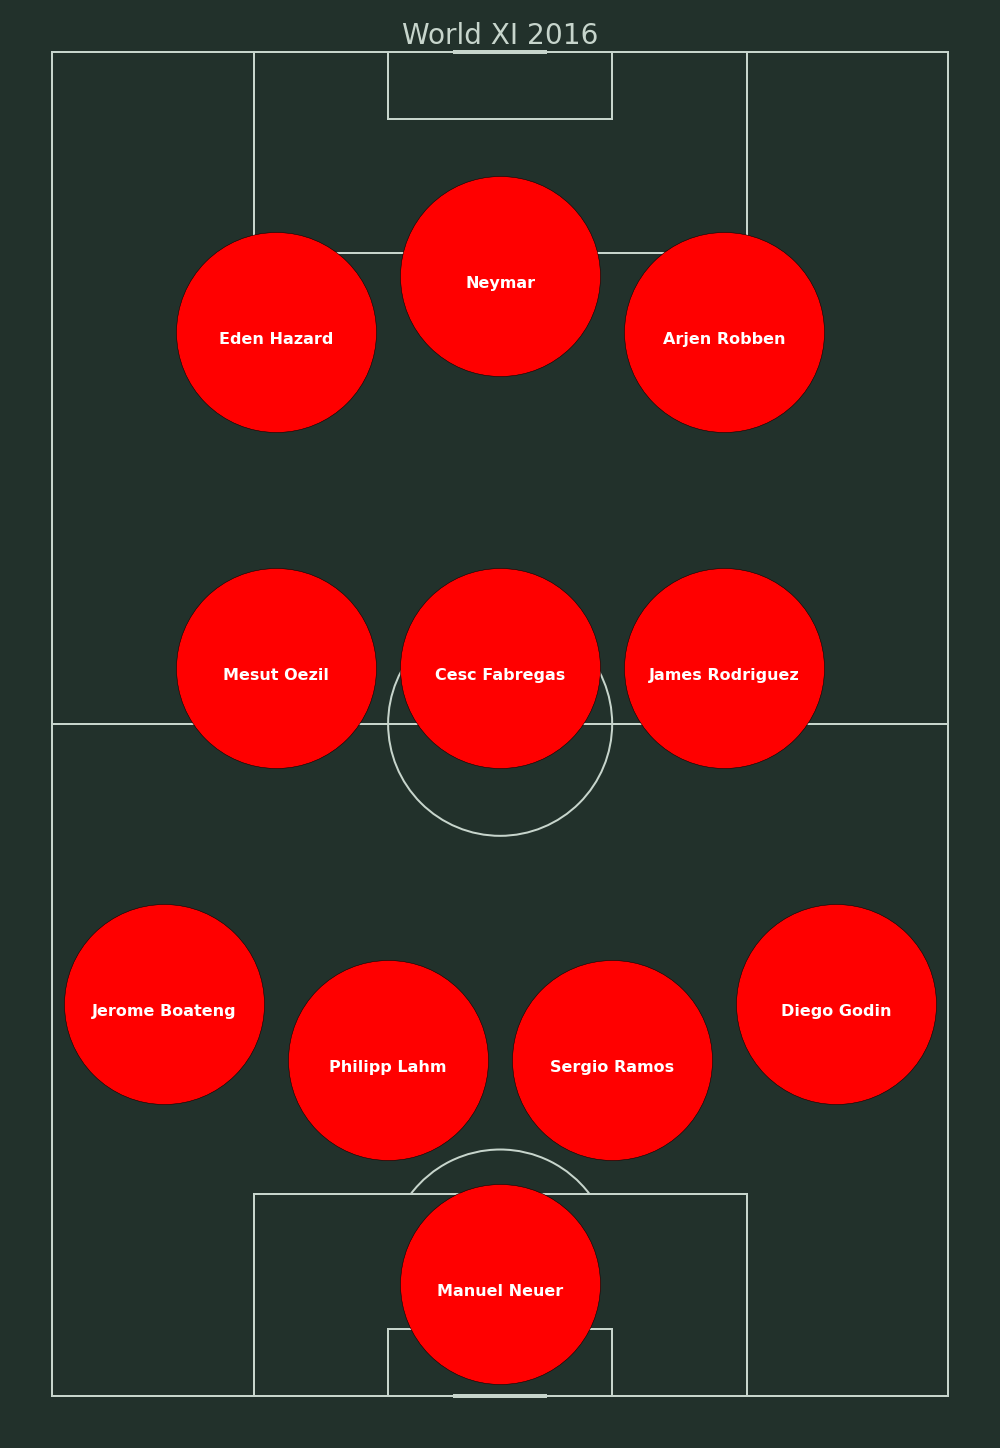